In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product e.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_e= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_e.shape

(60, 1)

In [5]:
sales_e.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_e['Sales'].sum()

4925930

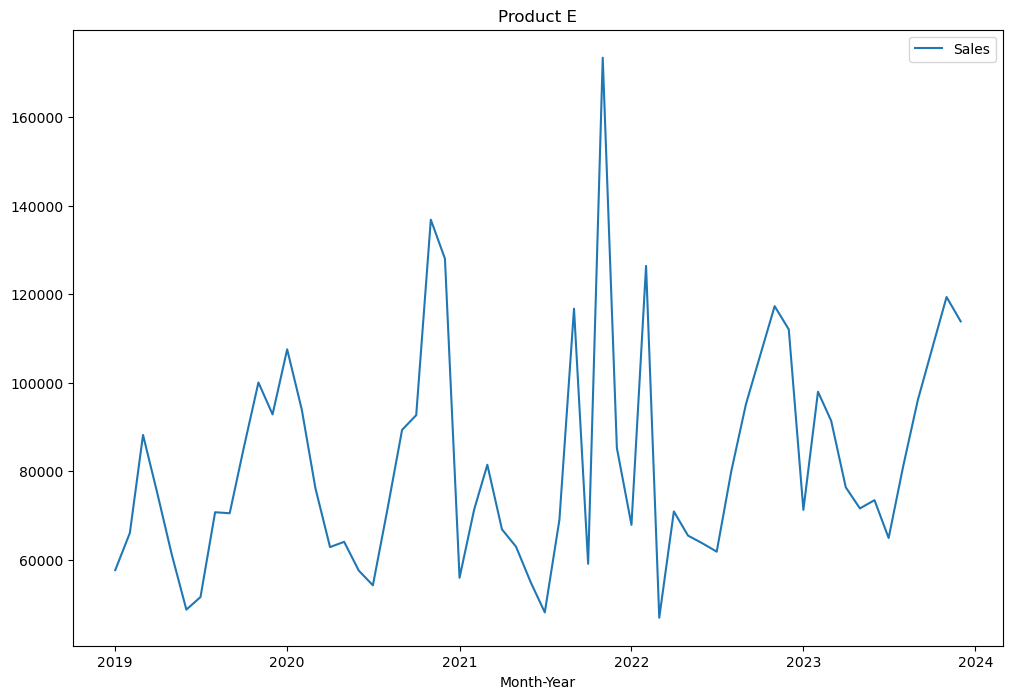

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e)
plt.title('Product E')
plt.show()

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_e)

ADF Statistics: -1.547517694729824
p- value: 0.5098879012430942
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_e_diff= sales_e.diff().dropna()

Text(0.5, 1.0, 'Product E- First Difference')

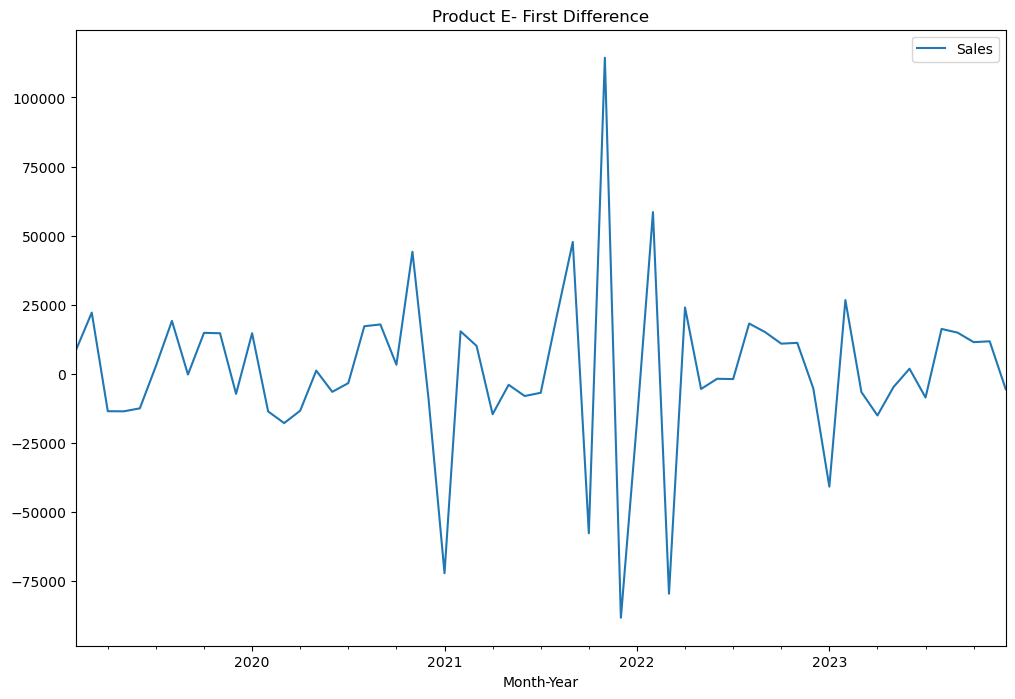

In [11]:
sales_e_diff.plot(figsize=(12, 8))
plt.title('Product E- First Difference')

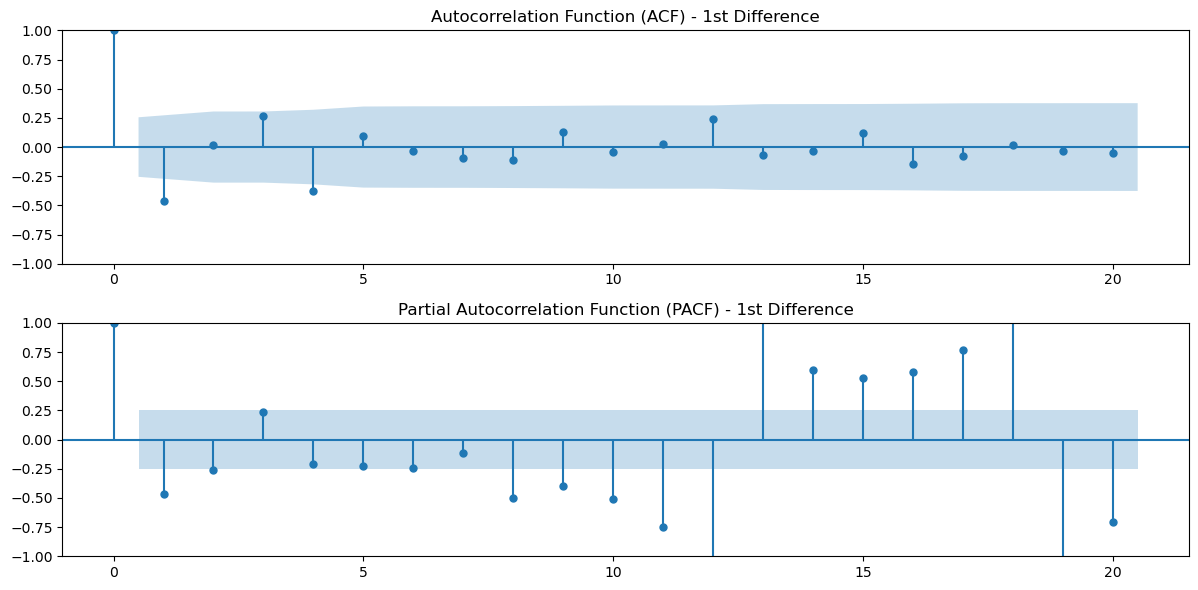

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_e_diff)

ADF Statistics: -6.125883961889508
p- value: 8.631648926998655e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_e[:48]
test=sales_e[48:]

In [15]:
print(len(train), len(test))

48 12


In [16]:
#combination p=(0,1,2,3,4,5) d=1 q=(0,1,2) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(1,1,0),(1,1,1),(1,1,2),(2,1,0), (2,1,1), (2, 1, 2),(3,1,0),(3,1,1),(3,1,2),(4,1,0),(4,1,1),(4,1,2),(5,1,0),(5,1,1),(5,1,2)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_e, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_e)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1096.562310  1109.513343  10021.337806  1.440424e+08  12001.767387
13  4  1  1097.587678  1108.688563  14131.722112  2.860654e+08  16913.468417
17  5  2  1098.007511  1112.808692  10681.352954  1.619074e+08  12724.283988
16  5  1  1098.908763  1111.859796  13528.878839  2.631061e+08  16220.547127
7   2  1  1101.451602  1108.852193  26464.125207  9.681356e+08  31114.878174
15  5  0  1102.223394  1113.324279  19376.390880  5.173205e+08  22744.680609
1   0  1  1102.244350  1105.944645  21865.997100  6.628129e+08  25745.152760
9   3  0  1102.561541  1109.962132  28250.776106  1.078622e+09  32842.379404
12  4  0  1102.583769  1111.834507  23702.841595  7.771744e+08  27877.847303
6   2  0  1103.053543  1108.603986  25439.462842  8.925061e+08  29874.841422
8   2  2  1103.066628  1112.317366  25783.942682  9.154060e+08  30255.677068
3   1  0  1103.111119  1106.811414  25932.966011  9.317024e+08  30523.801230

In [20]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -541.281
Date:                Thu, 09 May 2024   AIC                           1096.562
Time:                        17:26:40   BIC                           1109.513
Sample:                    01-01-2019   HQIC                          1101.436
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8752      0.268      3.271      0.001       0.351       1.400
ar.L2         -0.0031      0.264     -0.012      0.991      -0.521       0.515
ar.L3         -0.0596      0.231     -0.258      0.7

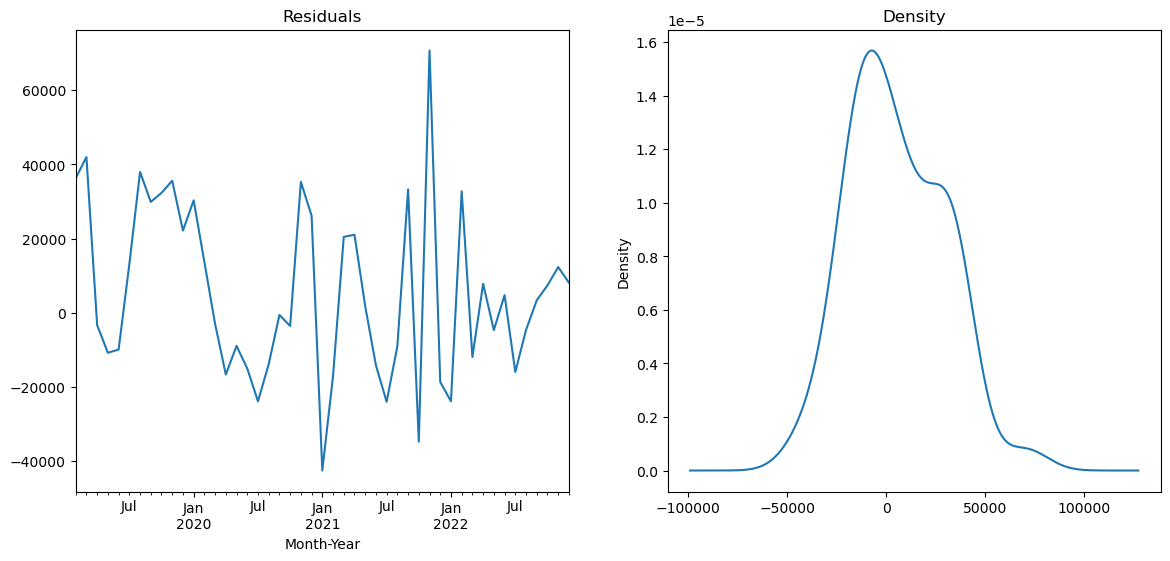

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

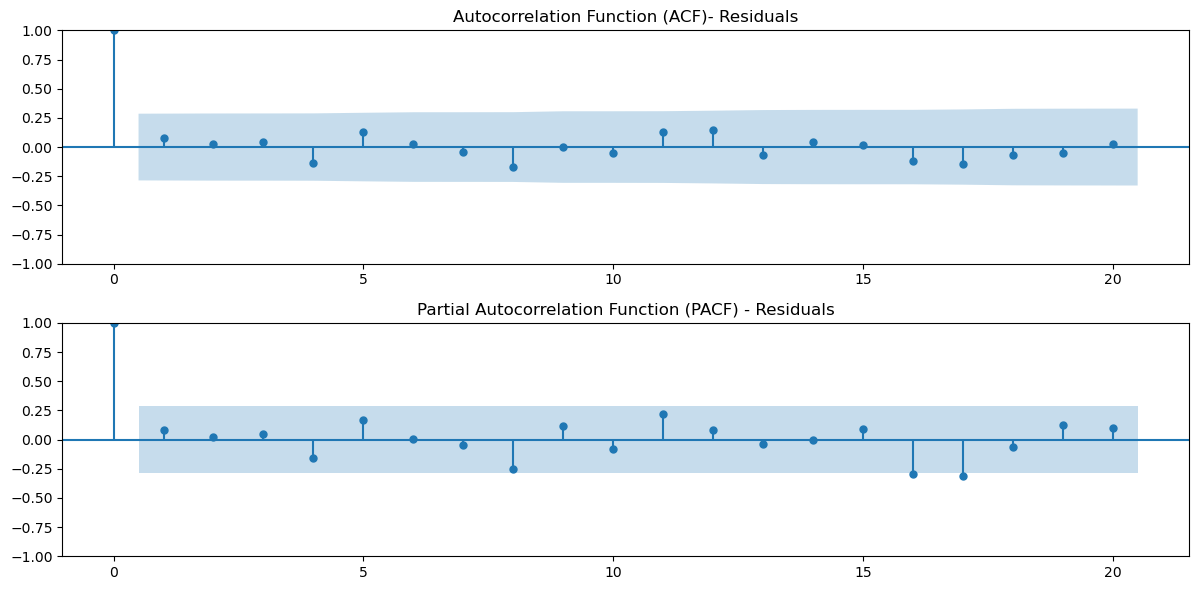

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

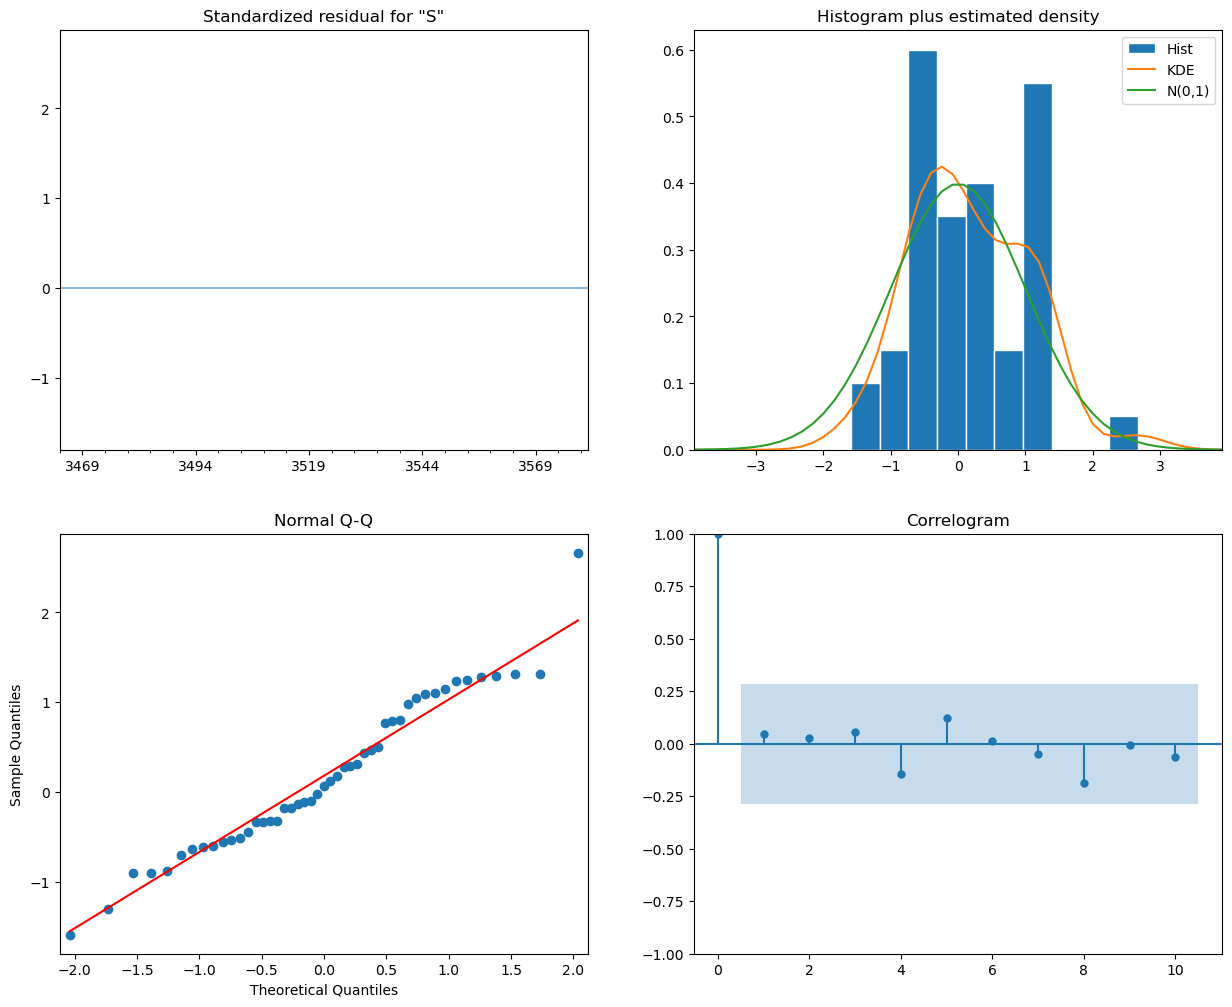

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_e['Forecast_ARIMA']=[None]*len(train) + list(pred)
#plt.figure(figsize=(14, 6))
#sales_e.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_e)-1), dynamic = True)
sales_e['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product E')

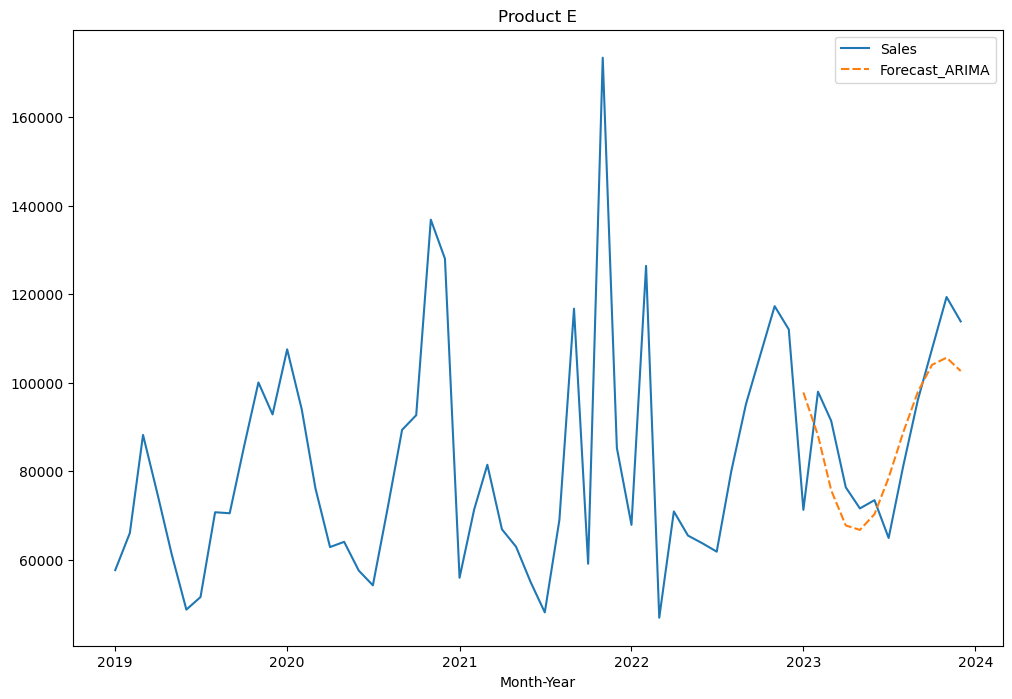

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e)
plt.title('Product E')

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 10021.337805647943
MAPE - ARIMA: 0.11978161445807299
MSE - ARIMA: 144042420.40146175
RMSE - ARIMA: 12001.767386575268


# SARIMA

In [28]:
import statsmodels.api as sm

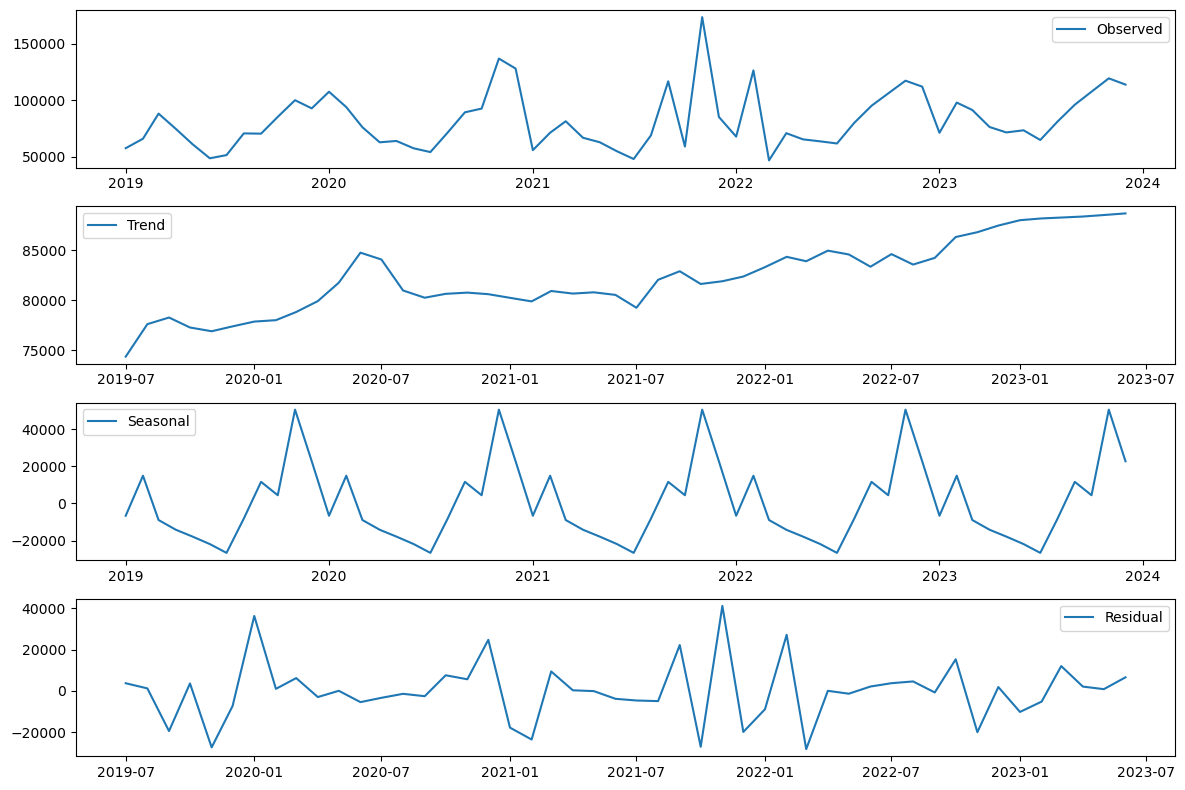

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_e['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

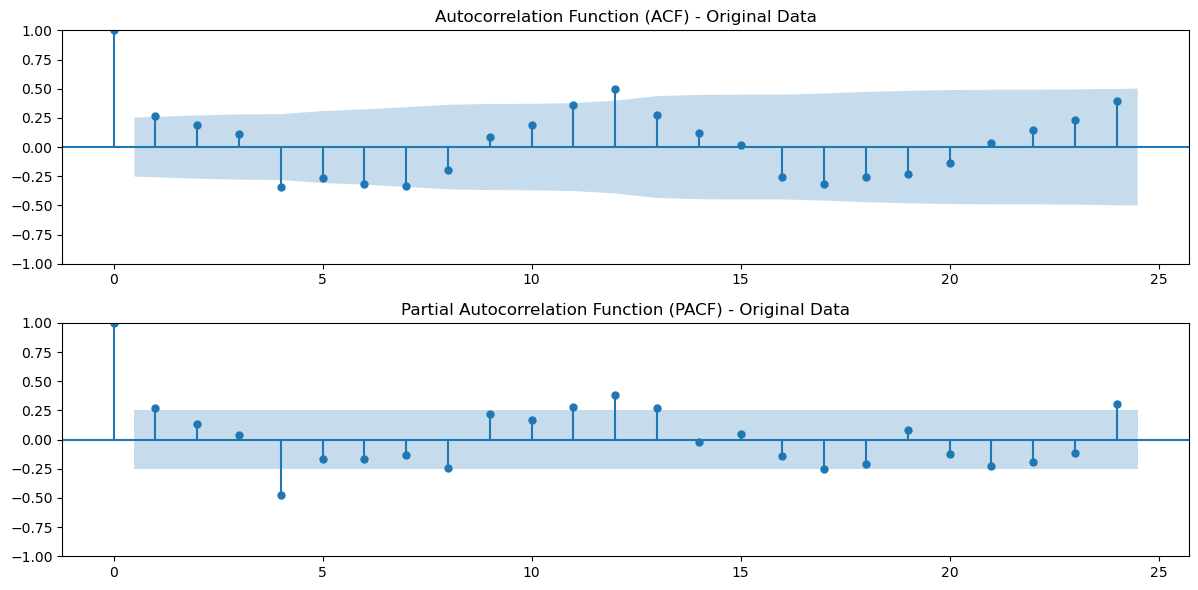

In [30]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

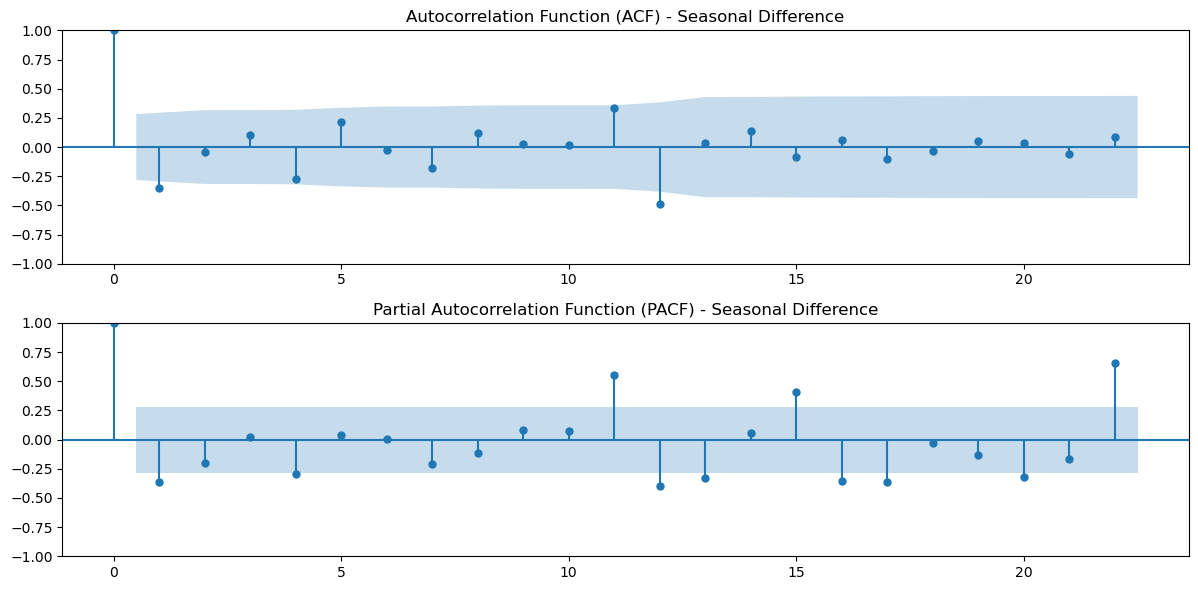

In [31]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_e['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

In [32]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(4):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [33]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic           mae           mse
1   0  1  832.678192  845.120976  11986.924142  2.145277e+08
5   1  1  834.468188  848.466320  12305.449152  1.953253e+08
2   0  2  834.903993  848.902126  15006.138078  2.585648e+08
12  3  0  835.122156  850.675636  39055.608462  1.568031e+09
3   0  3  836.252017  851.805497  14386.076634  2.563634e+08
9   2  1  836.285129  851.838610  23598.317674  5.975735e+08
8   2  0  836.457646  850.455778   7717.515625  9.557963e+07
6   1  2  836.812231  852.365711  15310.590918  2.689476e+08
13  3  1  837.054422  854.163250  37286.933886  1.425709e+09
16  4  0  837.056359  854.165188  37281.394932  1.425447e+09
4   1  0  837.461495  849.904280  13756.378805  2.253601e+08
10  2  2  837.663771  854.772600  24673.014079  6.498495e+08
7   1  3  838.026375  855.135204  16983.978640  3.355096e+08
17  4  1  839.054407  857.718583  37302.410685  1.426603e+09
14  3  2  839.054416  857.718592  37171.541111  1.417259e+09
20  5  0  839.054491  85

In [34]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 1),seasonal_order=(0,1,1,12))
sarima_model=sarima.fit()

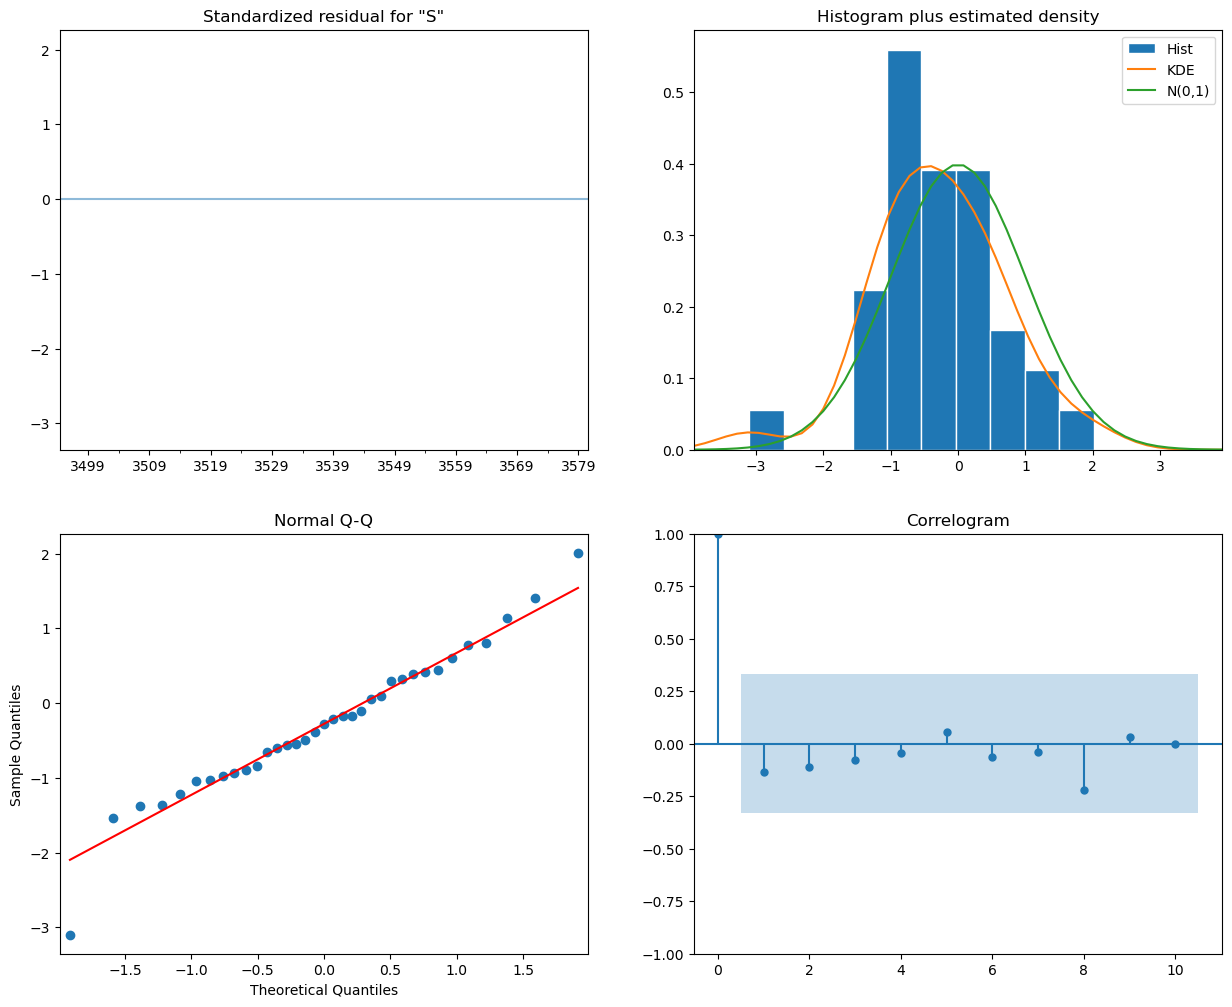

In [35]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [36]:
forecast_test_sarima=sarima_model.predict(start=48,end=59,dynamic=True)

In [37]:
sales_e['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product E')

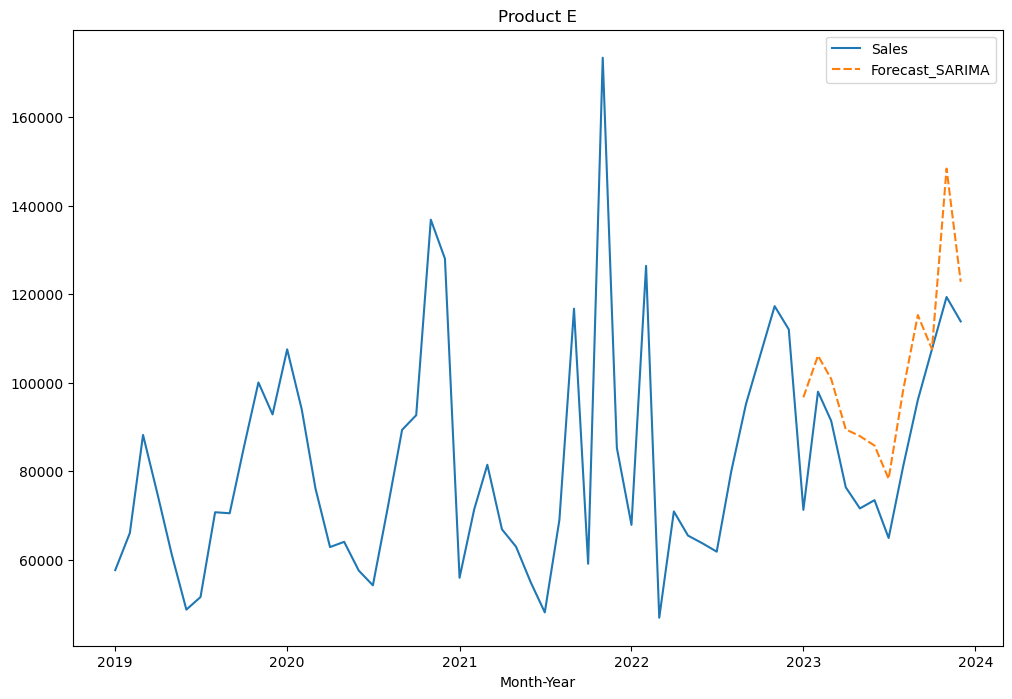

In [38]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_SARIMA']])
plt.title('Product E')

In [39]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 14385.672
MAPE - SARIMA: 0.171
MSE - SARIMA: 263421189.709
RMSE - SARIMA: 16230.255


# AUTO-ARIMA

In [43]:
import pmdarima as pm

In [44]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=3 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=851.050, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=842.630, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=844.349, Time=0.21 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=846.106, Time=1.27 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=843.277, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=844.594, Time=0.24 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=846.275, Time=0.56 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=848.049, Time=3.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=846.400, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=846.589, Time=0.50 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=848.275, Time=0.72 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=850.010, Time=4.55 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=846.540, Time=1.55 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=848.229, Time=2.91 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=849.939, Time=3.88 sec
 ARIMA(0,1

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [45]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -409.098
Date:                            Thu, 09 May 2024   AIC                            828.195
Time:                                    17:10:11   BIC                            835.972
Sample:                                01-01-2019   HQIC                           830.880
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4259      0.121    -11.814      0.000      -1.662      -1.189
ar.L2         -0.6564      0.166     -3.965      0.000      -0.981      -0.332
ma.L1          0.9807      0.322      3.050      0.002       0.350       1.611
ma.S.L12      -0.6929      0.374     -1.853      0.064      -1.426       0.040
sigma2      8.426e+08   4.31e-10   1.96e+18      0.000    8.43e+08    8.43e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 5.24
Prob(Q):                              0.51   Prob(JB):                         0.07
Heteroskedasticity (H):               0.34   Skew:                            -0.66
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+34. Standard errors may be unstable.
"""

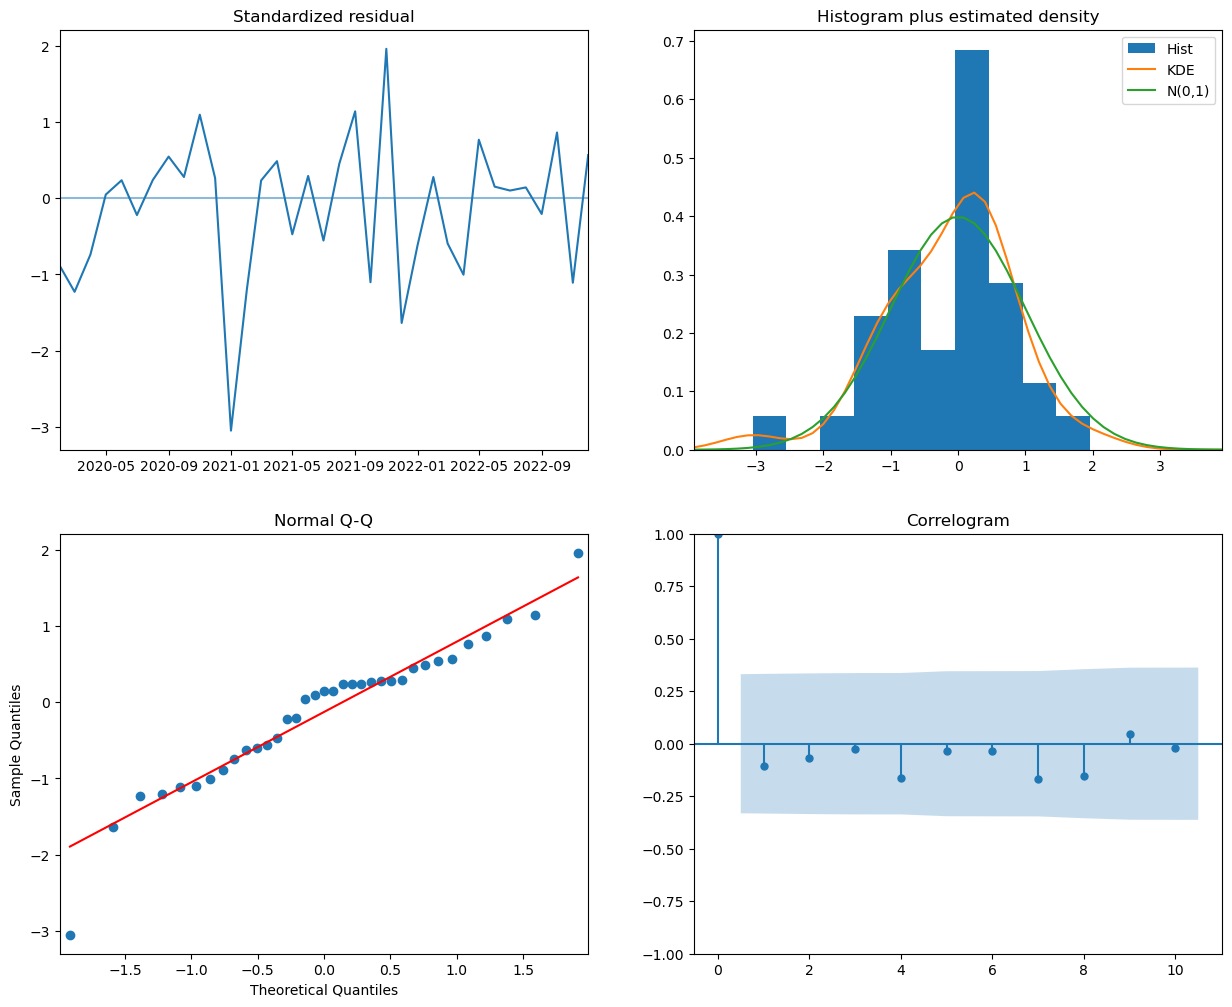

In [46]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [47]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_e['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_e[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product E')

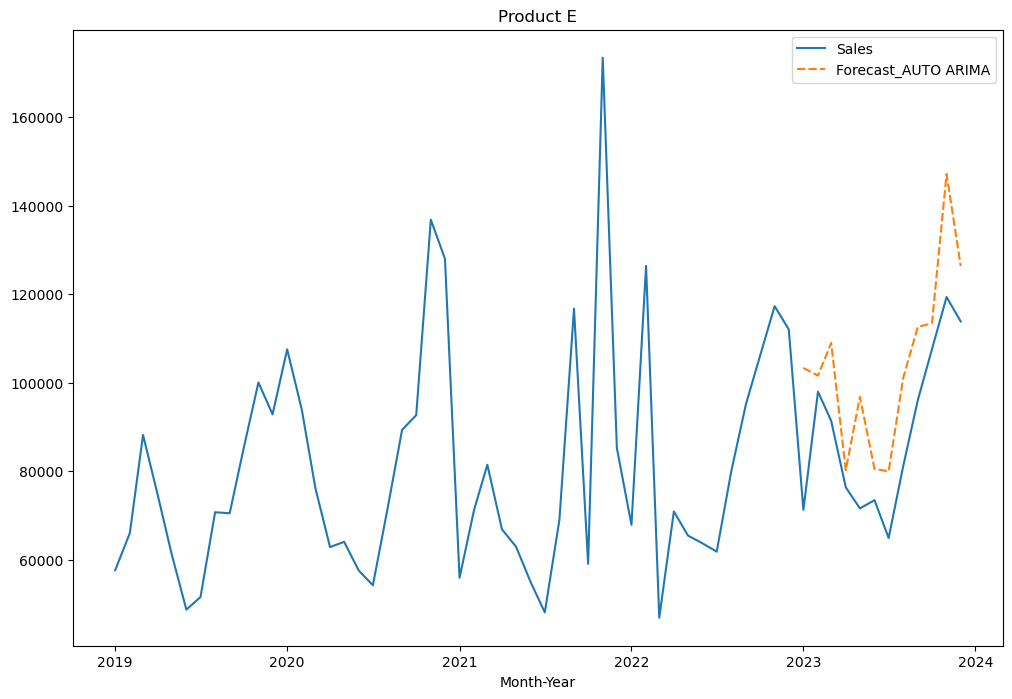

In [48]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product E')

In [49]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 15595.836350844278
MAPE - AUTO ARIMA: 0.18545426856058547
MSE - AUTO ARIMA: 326135255.8145881
RMSE - AUTO ARIMA: 18059.215260209625


In [50]:
sales_e.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,71268,97592.464896,96710.213052,103330.092702
2023-02-01,97965,89071.128607,106112.198835,101611.906570
2023-03-01,91393,78599.972000,100873.824607,108993.773767
2023-04-01,76364,75149.764869,89449.129085,80214.005218
2023-05-01,71591,77513.515251,87936.756709,96809.582304
2023-06-01,73457,80142.393570,85793.078796,80530.781084
2023-07-01,64909,85494.940631,78287.415526,79963.624440
2023-08-01,81175,89090.998872,98406.737270,101103.765162
2023-09-01,96096,90351.336205,115295.489734,112619.333977


In [51]:
sales_e.mean()

Sales                   82098.833333
Forecast_ARIMA          85859.663425
Forecast_SARIMA        103138.005451
Forecast_AUTO ARIMA    104348.169684
dtype: float64

In [52]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,14131.722112,0.158844,2.860654e+08,16913.468417
AUTO ARIMA,15595.836351,0.185454,3.261353e+08,18059.215260
SEASONAL ARIMA,14385.672117,0.170958,2.634212e+08,16230.255380


# TESTING

In [19]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=6,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=840.073, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=841.958, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=842.613, Time=0.29 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=841.991, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=842.832, Time=0.30 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=843.586, Time=1.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=842.694, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=844.687, Time=0.16 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=844.454, Time=0.43 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=844.689, Time=0.19 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,1)(2,1,0)[12] inter

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [20]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -418.036
Date:                  Wed, 08 May 2024   AIC                            840.073
Time:                          19:14:12   BIC                            843.240
Sample:                      01-01-2019   HQIC                           841.178
                           - 12-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4058.5000   4560.524      0.890      0.374   -4879.964     1.3e+04
sigma2       7.14e+08   1.81e+08      3.945      0.000    3.59e+08    1.07e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.64   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.03   Prob(JB):                         0.76
Heteroskedasticity (H):               2.00   Skew:                            -0.29
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_e['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product E')

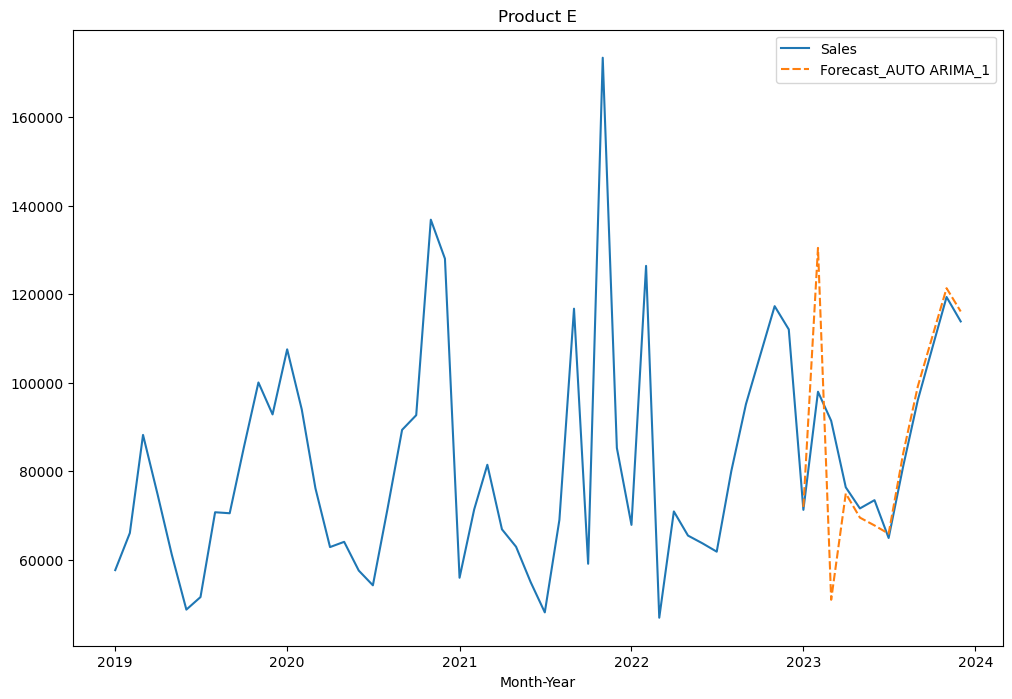

In [22]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product E')

In [23]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 8047.666666666668
MAPE - AUTO ARIMA: 0.08766228045242129
MSE - AUTO ARIMA: 230522836.41666663
RMSE - AUTO ARIMA: 15182.97850939224
